# Plotting API Results: GeoPandas, Matplotlib and Contextily

The quickest way to get a plot of your results is by using [GeoPandas](https://geopandas.org/en/stable/index.html) and its in-built [Matplotlib](https://matplotlib.org/stable/index.html) functionality. There are some good examples of the range of visualizations GeoPandas supports in their [gallery](https://geopandas.org/en/stable/gallery/index.html). The addition of [Contextily](https://contextily.readthedocs.io/en/stable/) lets you add basemaps to your plots, giving your data real world context.

## GeoPandas
The API returns GeoJSON, which can be used to make a GeoPandas GeoDataFrame. GeoDataFrames work in a very similar way to Pandas DataFrames, with the additional capability for manipulating geospatial data. GeoPandas allows you to quickly visualize the data returned by your API query, using the coordinate reference system of the data to accurately plot the spatial relationships. Plotting this way can an be useful to quickly check your API query results are looking like you were expecting, as well as giving you options to produce highly polished plots (see their [gallery](https://geopandas.org/en/stable/gallery/index.html) for more ideas).

This example requests surface water features along a section of the Glastonbury Canal in Somerset from the Zoomstack Surface Water product via the Features API and then makes a simple plot to show what was returned.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from osdatahub import Extent
from osdatahub import FeaturesAPI 
import os
os.environ['PROJ_NETWORK'] = 'OFF'

In [2]:
# Choose data product
product = 'zoomstack_surface_water'

# Define query extent
W, S = (342730, 137700)
E, N = (347700, 141642)
crs = "EPSG:27700"
extent = Extent.from_bbox((W, S, E, N), crs=crs)

# Query API
key = os.environ.get("OS_API_KEY")
surface_water = FeaturesAPI(key, product, extent)
surface_water_results = surface_water.query(limit=100000)

The API results are in GeoJSON format. We can use the [`geopandas.GeoDataFrame.from_features()`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.from_features.html?highlight=from_features) method to convert the dictionary-like format of GeoJSON into the easy to manipulate GeoDataFrame format. 

In [3]:
surface_water_gdf = gpd.GeoDataFrame.from_features(surface_water_results['features'], crs=crs)

Now it is as simple as calling `.plot()` on the dataframes, including some optional styling parameters, to visualise the results.

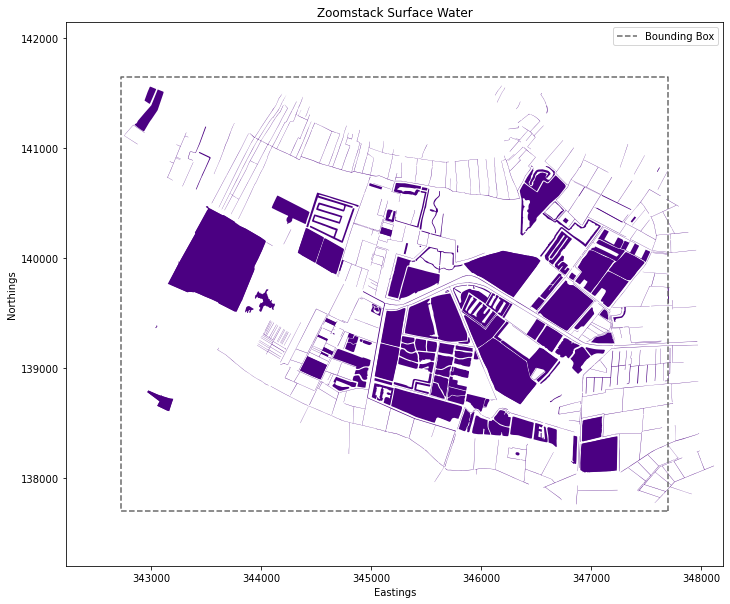

In [5]:
ax = surface_water_gdf.plot(color="indigo", figsize=(12, 10))

# Plot the query extent
ax.plot(*zip(*extent.polygon.exterior.coords), color="dimgray",
        linestyle='--', label="Bounding Box")

# Define limits of the plot
bounds = extent.polygon.bounds
# margin adds a bit of space around the bounding box
margin = 500
x_limits = (bounds[0] - margin, bounds[2] + margin)
y_limits = (bounds[1] - margin, bounds[3] + margin)
ax.set_xlim(*x_limits)
ax.set_ylim(*y_limits)

# Add labels
ax.set_xlabel("Eastings")
ax.set_ylabel("Northings")
ax.set_title("Zoomstack Surface Water")
plt.legend()
plt.show()

This plot show us the features returned from the API and plots them correctly in geographic space. Once we've checked the results look sensible, it would be nice to see how the features relate to the rest of the geography of the area. To do this we might want to add a base map, which we can do using Contextily.

## Contextily
[Contextily](https://contextily.readthedocs.io/en/stable/) works with matplotlib plots to supply a basemap you can plot your query results onto. You can use the OS Maps API with contextily to get a variety of different basemaps. Find out more about the OS Maps API [here](https://osdatahub.os.uk/docs/wmts/overview).

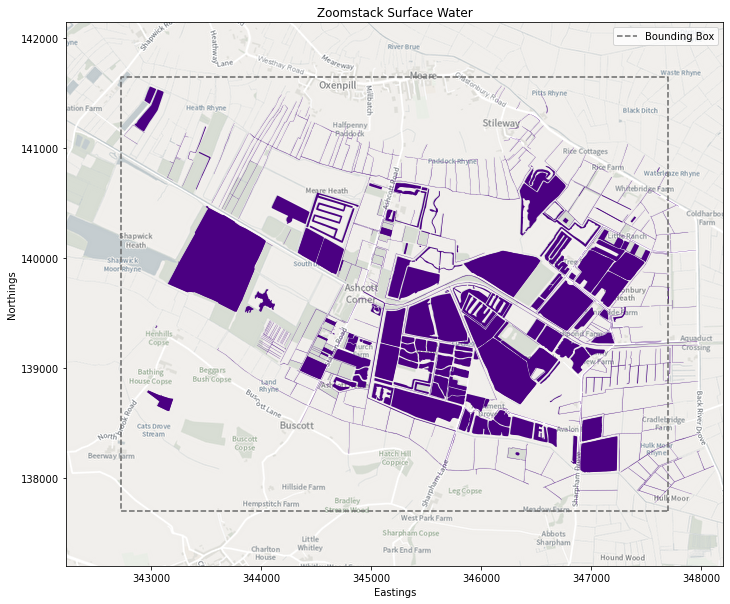

In [6]:
import contextily as ctx

# Make the same plot as above, ready to add in a base map.
ax = surface_water_gdf.plot(color="indigo", figsize=(12, 10))
ax.plot(*zip(*extent.polygon.exterior.coords), color="dimgray",
        linestyle='--', label="Bounding Box")

# Define limits of the plot
ax.set_xlim(*x_limits)
ax.set_ylim(*y_limits)

# Add title and labels
ax.set_xlabel("Eastings")
ax.set_ylabel("Northings")
ax.set_title("Zoomstack Surface Water")
plt.legend()

# Add the basemap. Note: contextily only works with EPSG:3857 basemaps, but will convert it to match the data crs
basemap_url = "https://api.os.uk/maps/raster/v1/zxy/Light_3857/{z}/{x}/{y}.png?key=" + key
ctx.add_basemap(ax, source=basemap_url, crs=surface_water_gdf.crs, interpolation="sinc")

plt.show()